# Step 1: Importing Libraries and Data

In [1]:
#Check to see if Latest version of fastai is installed. Using pip install as it's a bash function
!pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


In [2]:
#Using duckduckgo search engine for training set images
from duckduckgo_search import ddg_images
from fastcore.all import *

#Creating function to extract set number of images based on given keyword
def search_images(term, max_images=80):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Time to test our function on our target category

In [3]:
#extracting a sample image link
urls = search_images('portrait wearing face mask', max_images=1)
urls[0]

Searching for 'portrait wearing face mask'


'https://images.pexels.com/photos/4472634/pexels-photo-4472634.jpeg?cs=srgb&dl=man-wearing-face-mask-4472634.jpg&fm=jpg'

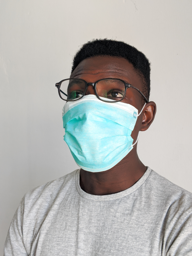

In [4]:
#using fastai to download the pic for later test usage
from fastdownload import download_url
test_img = 'wearing_mask.jpg'
download_url(urls[0], test_img, show_progress=False)

from fastai.vision.all import *
im = Image.open(test_img)
im.to_thumb(256,256)

Carrying out the same process for the non compliant category

Searching for 'portrait'


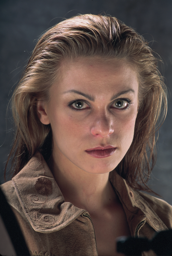

In [5]:
#previous functions merged into one
download_url(search_images('portrait', max_images=1)[0], 'test_img2.jpg', show_progress=False)
Image.open('test_img2.jpg').to_thumb(256,256)

Making the training set now by downloading many images from the same searching criterias

In [6]:
#obtaining images
searches = 'portrait','portrait wearing face mask'
path = Path('mask_or_not')
from time import sleep

for o in searches:
    test_img = (path/o)
    test_img.mkdir(exist_ok=True, parents=True)
    download_images(test_img, urls=search_images(f'{o}'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(test_img, urls=search_images(f'{o} woman'))
    sleep(5)
    download_images(test_img, urls=search_images(f'{o} man'))
    sleep(5)
    resize_images(path/o, max_size=400, test_img=path/o)

Searching for 'portrait'
Searching for 'portrait woman'
Searching for 'portrait man'
Searching for 'portrait wearing face mask'
Searching for 'portrait wearing face mask woman'
Searching for 'portrait wearing face mask man'


# Step 2: Training the Model

In [7]:
#removing failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

Using DataLoaders command now to split and clean our data

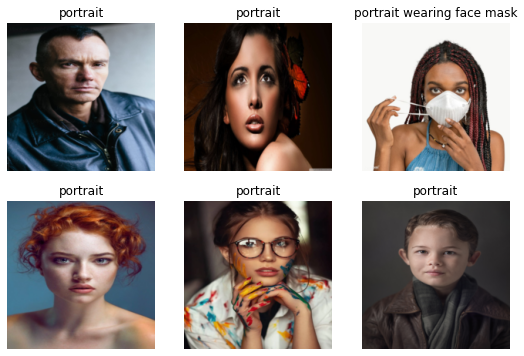

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.806388,0.136608,0.043011,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.276362,0.040192,0.021505,00:55
1,0.185158,0.019692,0.000000,00:54
2,0.128201,0.013405,0.000000,00:55


# Step 3: Testing the Model


In [10]:
wearing_mask,_,probs = learn.predict(PILImage.create('wearing_mask.jpg'))
print(f"This person is: {wearing_mask}.")
print(f"Probability This Person is wearing a mask: {1-probs[0]:.4f}")

This person is: portrait wearing face mask.
Probability This Person is wearing a mask: 1.0000


Searching for 'Person with hoodie portrait'


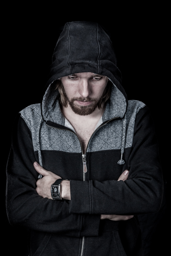

In [11]:
#previous functions merged into one
download_url(search_images('Person with hoodie portrait', max_images=1)[0], 'final_test1.jpg', show_progress=False)
Image.open('final_test1.jpg').to_thumb(256,256)

In [12]:
wearing_mask,_,probs = learn.predict(PILImage.create('final_test1.jpg'))
print(f"This person is: {wearing_mask}.")
print(f"Probability This Person is wearing a mask: {1-probs[0]:.4f}")

This person is: portrait.
Probability This Person is wearing a mask: 0.2484


Searching for ' face mask side  '


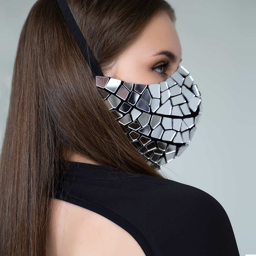

In [13]:
download_url(search_images('face mask side', max_images=1)[0], 'final_test2.jpg', show_progress=False)
Image.open('final_test1.jpg').to_thumb(256,256)

In [14]:
wearing_mask,_,probs = learn.predict(PILImage.create('final_test2.jpg'))
print(f"This person is: {wearing_mask}.")
print(f"Probability This Person is wearing a mask: {1-probs[0]:.4f}")

This person is: portrait wearing face mask.
Probability This Person is wearing a mask: 0.9995


Searching for ' white  face mask '


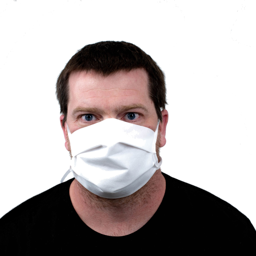

In [15]:
#previous functions merged into one
download_url(search_images(' white  face mask ', max_images=1)[0], 'final_test3.jpg', show_progress=False)
Image.open('final_test3.jpg').to_thumb(256,256)

In [16]:
wearing_mask,_,probs = learn.predict(PILImage.create('final_test3.jpg'))
print(f"This person is: {wearing_mask}.")
print(f"Probability This Person is wearing a mask: {1-probs[0]:.4f}")

This person is: portrait wearing face mask.
Probability This Person is wearing a mask: 1.0000


Searching for 'guy with big beard '


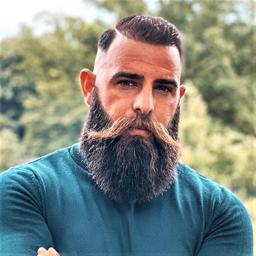

In [26]:

download_url(search_images('guy with big beard ', max_images=1)[0], 'final_test.jpg', show_progress=False)
Image.open('final_test.jpg').to_thumb(256,256)

In [27]:
wearing_mask,_,probs = learn.predict(PILImage.create('final_test.jpg'))
print(f"This person is: {wearing_mask}.")
print(f"Probability This Person is wearing a mask: {1-probs[0]:.4f}")

This person is: portrait.
Probability This Person is wearing a mask: 0.4394
